In [ ]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from glob import glob
from datetime import datetime
from tqdm import tqdm

from IPython.display import Audio
import torchaudio

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from soundbay.utils.metadata_processing import create_wav_info_df, convert_month_annotation_to_file_anotation

BASE_PATH = Path(os.getcwd())
DATASET_PATH = BASE_PATH / "datasets/fannie_project"
print(DATASET_PATH)

/mnt/d/DeepVoice/soundbay/datasets/fannie_project


## Find calls

Fannie saved the calls in the next way:
* opened all the files from a specific month
* saved all the calls in the same file

that means that the calls are time is from the begining of the month. <br>
we need to calculate the length of all previous files to make the correction for the annotation.

In [2]:
wav_info_df = create_wav_info_df(list(DATASET_PATH.rglob("*.wav")), wav_files_names_format="fannie")

load annotation file:

In [11]:
# load annotations into dataframe, they are saved as text file
mad_may_df = pd.read_csv(DATASET_PATH / "MAD_BLUE" / "LF_5756.210501002958.Table.1.selections.txt", sep="\t", on_bad_lines='skip')

In [8]:
annotation_df = convert_month_annotation_to_file_anotation(mad_may_df, wav_info_df)
annotation_df.head()

,Selection,View,Channel,High Freq (Hz),Low Freq (Hz),Peak Freq (Hz),Delta Time (s),Dur 90% (s),SNR NIST Quick (dB),wav_file,Begin Time (s),End Time (s)
0,1,Spectrogram 1,1,34.2,31.76,32.812,16.4435,13.2796,10.74,5756.210501002958,195.991555,212.435056
1,2,Spectrogram 1,1,34.2,31.76,33.398,15.4393,13.1651,9.75,5756.210501002958,571.004157,586.443474
2,3,Spectrogram 1,1,34.2,31.76,33.398,12.4895,11.1045,8.37,5756.210501012958,145.778519,158.268029
3,4,Spectrogram 1,1,34.5,31.46,33.398,16.9456,13.9665,16.11,5756.210501012958,557.870368,574.815960
4,5,Spectrogram 1,1,34.5,31.46,32.812,18.4519,14.7678,16.91,5756.210501012958,776.631872,795.083739


plot the calls

Playing 5756.210501002958.wav from 195.991555418 to 212.435055788


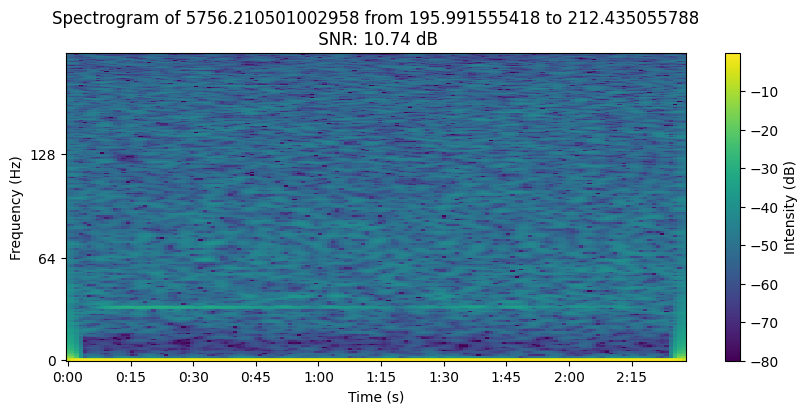

Playing 5756.210501002958.wav from 571.004157187 to 586.443474329


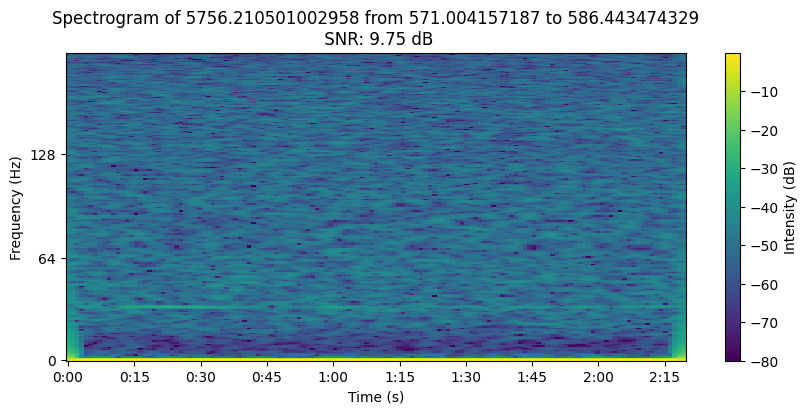

Playing 5756.210501012958.wav from 145.7785193950001 to 158.26802852600008


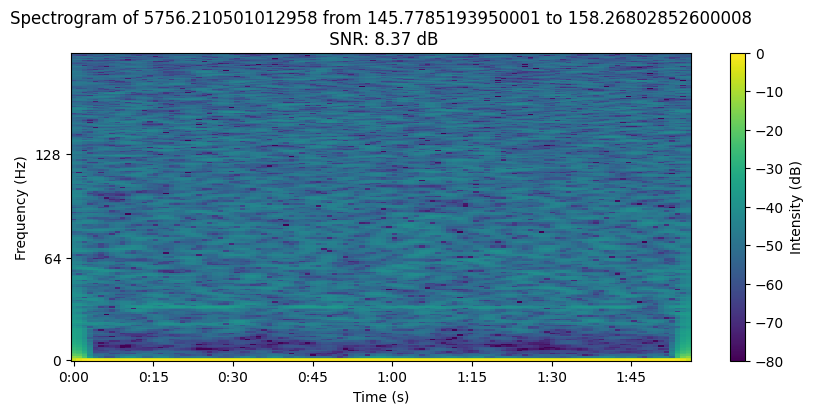

Playing 5756.210501012958.wav from 557.8703681350001 to 574.8159601200001


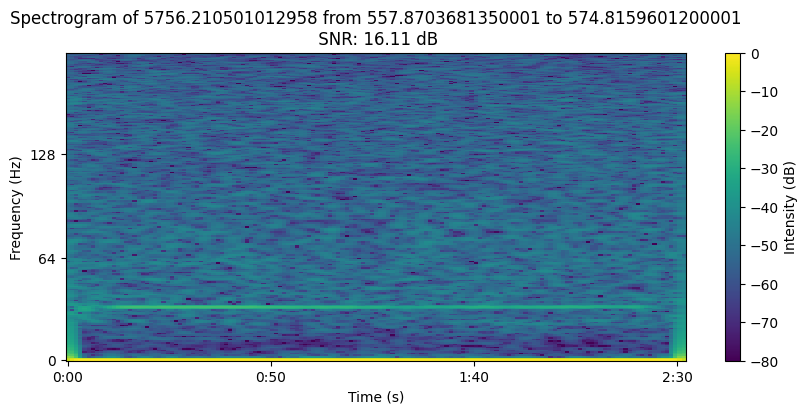

Playing 5756.210501012958.wav from 776.6318720140001 to 795.0837388420001


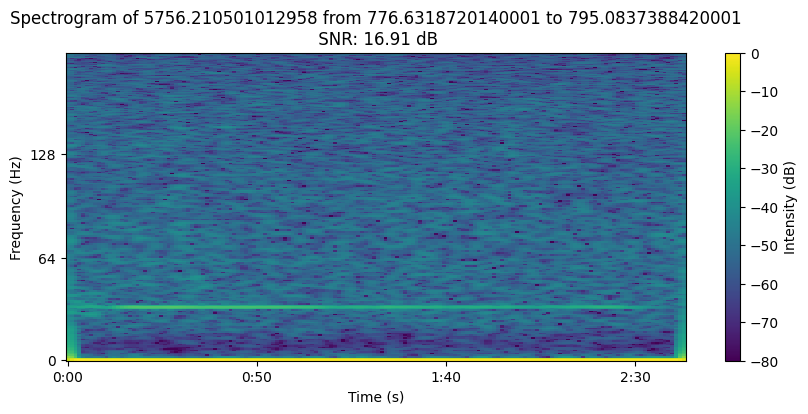

In [46]:
import librosa.display
# choose 5 random annotations from mad_may_df
# mad_may_df = mad_may_df.sample(5, random_state=42).reset_index(drop=True)
cnt = 0
for i, row in annotation_df.iterrows():
    if cnt == 5:
        break
    cnt += 1
    wav_file = row["wav_file"] + ".wav"
    audio, sr = torchaudio.load(str(DATASET_PATH / wav_file))
    if sr != 500:
        audio = torchaudio.functional.resample(audio, orig_freq=sr, new_freq=500)
        sr = 500
    plt.figure(figsize=(10, 4))
    # take first channel
    audio = audio[0].numpy()
    # cut only annotation
    audio = audio[int(sr * (row["Begin Time (s)"] - 1)) : int(sr * (row["End Time (s)"] + 1))]
    print(f"Playing {wav_file} from {row['Begin Time (s)']} to {row['End Time (s)']}")
    # plt.specgram(audio, Fs=sr, NFFT=512, noverlap=256, cmap='viridis', scale='dB')
    librosa.display.specshow(
        librosa.amplitude_to_db(np.abs(librosa.stft(audio, n_fft=512, hop_length=64)), ref=np.max),
        sr=sr, x_axis='time', y_axis='log', cmap='viridis'
    )
    # rect = patches.Rectangle(
    #     (1, row["Low Freq (Hz)"] - 2.5),  # (x, y): start at 1s before call, low freq
    #     row["End Time (s)"] - row["Begin Time (s)"],  # width: duration of call
    #     row["High Freq (Hz)"] - row["Low Freq (Hz)"] + 5,  # height: freq range
    #     linewidth=1, edgecolor='red', facecolor='none'
    # )
    # plt.gca().add_patch(rect)
    plt.title(f"Spectrogram of {row['wav_file']} from {row['Begin Time (s)']} to {row['End Time (s)']}\n SNR: {row['SNR NIST Quick (dB)']:.2f} dB")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(label="Intensity (dB)")
    plt.show()
Audio(audio, rate=sr)

# histograms of all anotations:

there are two types of animals in the annotations:
1. antarctice blue whales
2. Madagascan blue whales

In [15]:
## load all annotations files:

def load_all_anotation_from_folder(folder_path) -> pd.DataFrame:
    """
    Load all annotation files from a given folder and concatenate them into a single DataFrame.
    
    Args:
        folder_path (Path): Path to the folder containing annotation files.
        
    Returns:
        pd.DataFrame: Concatenated DataFrame containing all annotations.
    """
    annotations = list(folder_path.glob("*.txt"))
    ll = [pd.read_csv(f, sep="\t", on_bad_lines='skip') for f in annotations]
    df = pd.concat(ll, axis=0, ignore_index=True)
    return df

In [16]:
ant_blue_df = load_all_anotation_from_folder(DATASET_PATH / "ANT_BLUE")
ant_blue_df.head()

mad_blue_df = load_all_anotation_from_folder(DATASET_PATH / "MAD_BLUE")
mad_blue_df.head()

,Selection,View,Channel,Begin Time (s),End Time (s),High Freq (Hz),Low Freq (Hz),Peak Freq (Hz),Delta Time (s),Dur 90% (s),SNR NIST Quick (dB),Begin File
0,1,Spectrogram 1,1,211077.225452,211092.162677,34.2,31.934,32.812,14.9372,9.3873,12.55,LF_5756.210426052958.wav
1,2,Spectrogram 1,1,211418.547613,211431.853040,34.2,31.934,32.812,13.3054,10.8755,10.73,LF_5756.210426052958.wav
2,3,Spectrogram 1,1,211512.614570,211530.689868,34.2,31.934,33.398,18.0753,15.7981,7.90,LF_5756.210426052958.wav
3,4,Spectrogram 1,1,211619.484864,211635.551796,34.2,31.934,33.398,16.0669,12.9361,9.22,LF_5756.210426052958.wav
4,5,Spectrogram 1,1,211751.083170,211768.028762,34.5,31.649,32.812,16.9456,13.0506,8.45,LF_5756.210426062958.wav


In [ ]:
ant_blue_df["Species"] = "Antarctic Blue Whale"
mad_blue_df["Species"] = "Mediterranean Blue Whale"
all_whales_df = pd.concat([ant_blue_df, mad_blue_df], axis=0, ignore_index=True)

In [18]:
ant_blue_df.columns

Index(['Selection', 'View', 'Channel', 'Begin Time (s)', 'End Time (s)',
       'High Freq (Hz)', 'Low Freq (Hz)', 'Peak Freq (Hz)', 'Delta Time (s)',
       'Dur 90% (s)', 'SNR NIST Quick (dB)', 'Begin File'],
      dtype='object')

In [42]:
print("# annotations for Antarctic Blue Whales:", len(ant_blue_df))
print("# annotations for MAD Blue Whales:", len(mad_blue_df))

# annotations for Antarctic Blue Whales: 5441
# annotations for MAD Blue Whales: 9607


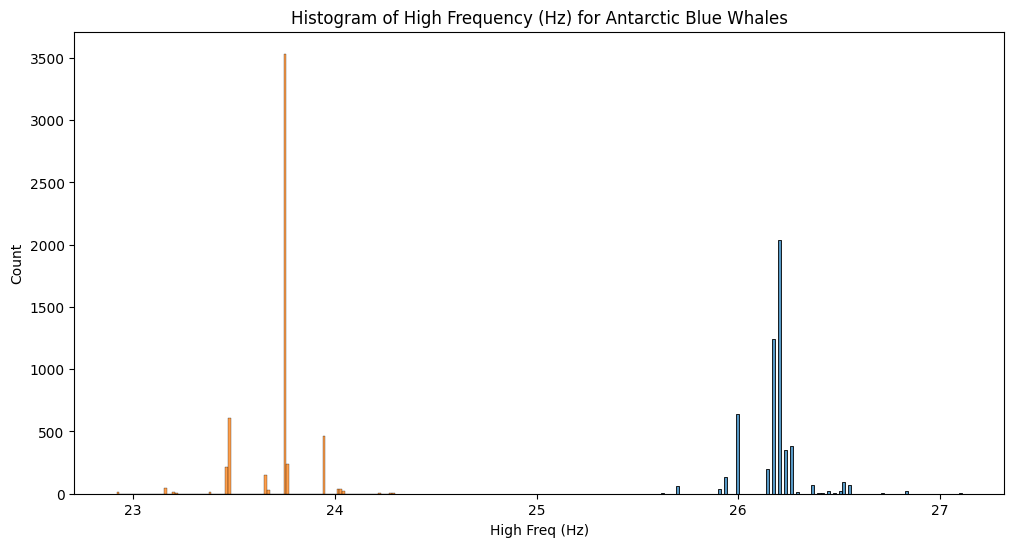

In [28]:
plt.figure(figsize=(12, 6))
sns.histplot(data = ant_blue_df, x = "High Freq (Hz)", bins=100)
sns.histplot(data = ant_blue_df, x = "Low Freq (Hz)", bins=100)
plt.title("Histogram of Frequency (Hz) for Antarctic Blue Whales")
plt.show()

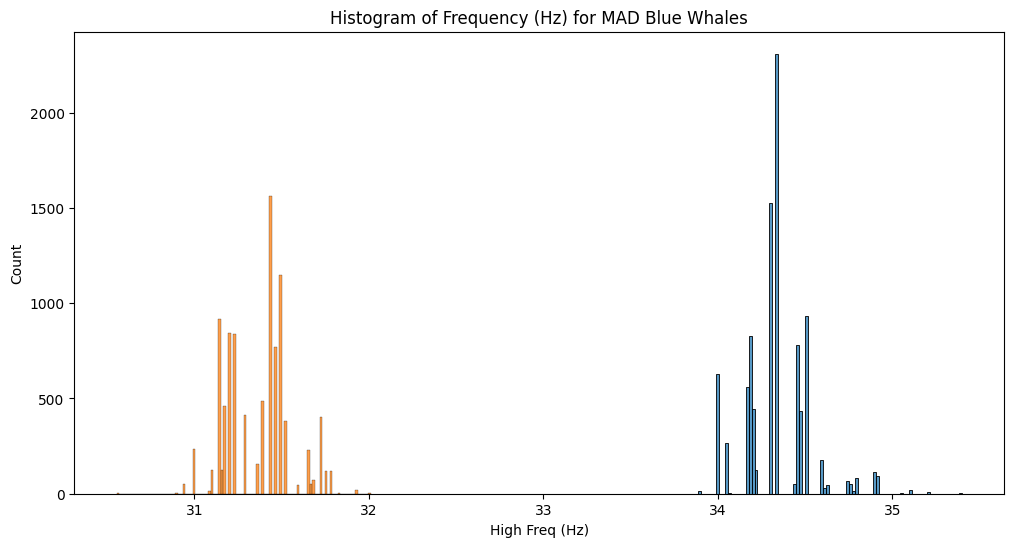

In [31]:
plt.figure(figsize=(12, 6))
sns.histplot(data = mad_blue_df, x = "High Freq (Hz)", bins=100)
sns.histplot(data = mad_blue_df, x = "Low Freq (Hz)", bins=100)
plt.title("Histogram of Frequency (Hz) for MAD Blue Whales")
plt.show()

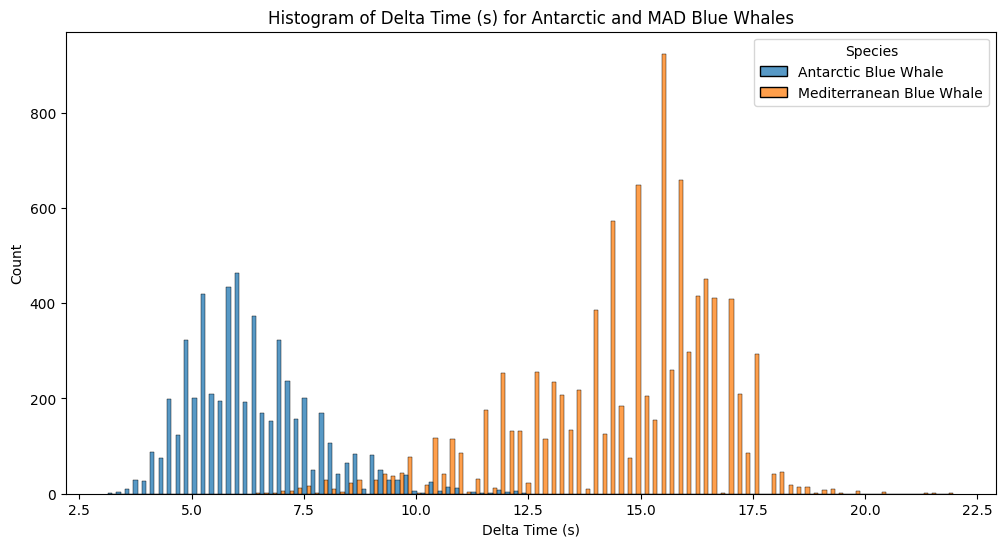

In [36]:
plt.figure(figsize=(12, 6))
sns.histplot(data = all_whales_df, x = "Delta Time (s)", hue = "Species", multiple="dodge", bins=100)
plt.title("Histogram of Delta Time (s) for Antarctic and MAD Blue Whales")
plt.show()

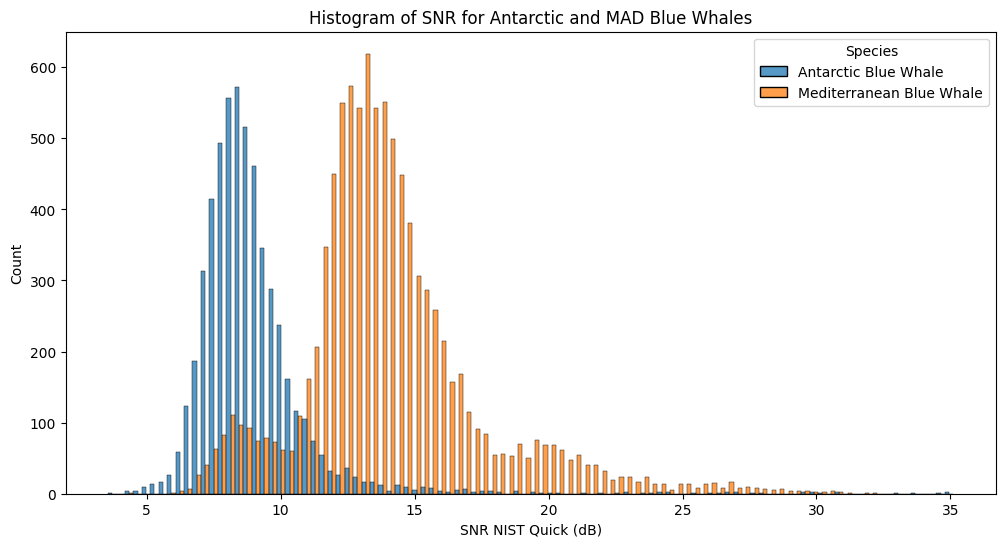

In [43]:
plt.figure(figsize=(12, 6))
sns.histplot(data = all_whales_df, x = "SNR NIST Quick (dB)", hue = "Species", multiple="dodge", bins=100)
plt.title("Histogram of SNR for Antarctic and MAD Blue Whales")
plt.show()